In [1]:
# Change directory to the parent directory
import os
os.path.abspath(os.curdir)
os.chdir("..")
os.getcwd()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from source import *

from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Extension: Natural Gas Model

Following the replication of the paper, it was concluded that climate related disaster frequency and the CPU index has limited predictive power on the volatility of natural gas prices.

As natural gas, along with other commodities, are physical assets that are highly constrained by demand and supply fundamentals, 

In [2]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('./data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('./data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('./data/natgas_futures_price.csv', sep=',')

# Average Monthly Temperature in top 5 natural gas consuming states - Texas, Caslifornia, Pennsylvania, Louisiana, Florida
# Source: https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series
avg_temp = pd.read_csv('./data/top5_consumption_states.csv')

# EIA Natural gas storage data
# Source: https://ir.eia.gov/ngs/notes.html
storage = pd.read_csv('./data/ngstorage.csv')
    


In [3]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%Y-%m-%d')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Average Temperature
avg_temp['Date'] = pd.to_datetime(avg_temp['Date'],format='%Y-%m-%d')
avg_temp.set_index('Date', inplace = True)
avg_temp['South'] = avg_temp.loc[:, avg_temp.columns != 'Pennsylvannia'].mean(axis = 1)
avg_temp['North'] = avg_temp['Pennsylvannia']
avg_temp = avg_temp[['North', 'South']]

# Storage
storage =\
(
    storage
    .groupby(
        pd.to_datetime(storage['Week Ending'])
        .dt
        .to_period('M'))
    .apply(lambda x: x.loc[x['Week Ending'].idxmax()])
    [['Total']]
)
storage = storage.rename(columns={"Total": "Storage"})

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')
avg_temp['YYYY-MM'] = avg_temp.index.to_period('M')
storage['YYYY-MM'] = storage.index

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            avg_temp,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            storage,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data = data.loc[data.index <= '2023-05-26']
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq,North,South,Storage
Date,,,,,,,,
1993-12-01,2.198,-2.026640,1993-12,50.923913,20,28.8,49.75,2322.0
1993-12-02,2.135,-2.908121,1993-12,50.923913,20,28.8,49.75,2322.0
1993-12-03,2.153,0.839557,1993-12,50.923913,20,28.8,49.75,2322.0
1993-12-06,2.033,-5.734968,1993-12,50.923913,20,28.8,49.75,2322.0
1993-12-07,2.054,1.027658,1993-12,50.923913,20,28.8,49.75,2322.0


# Exploratory Data Analysis

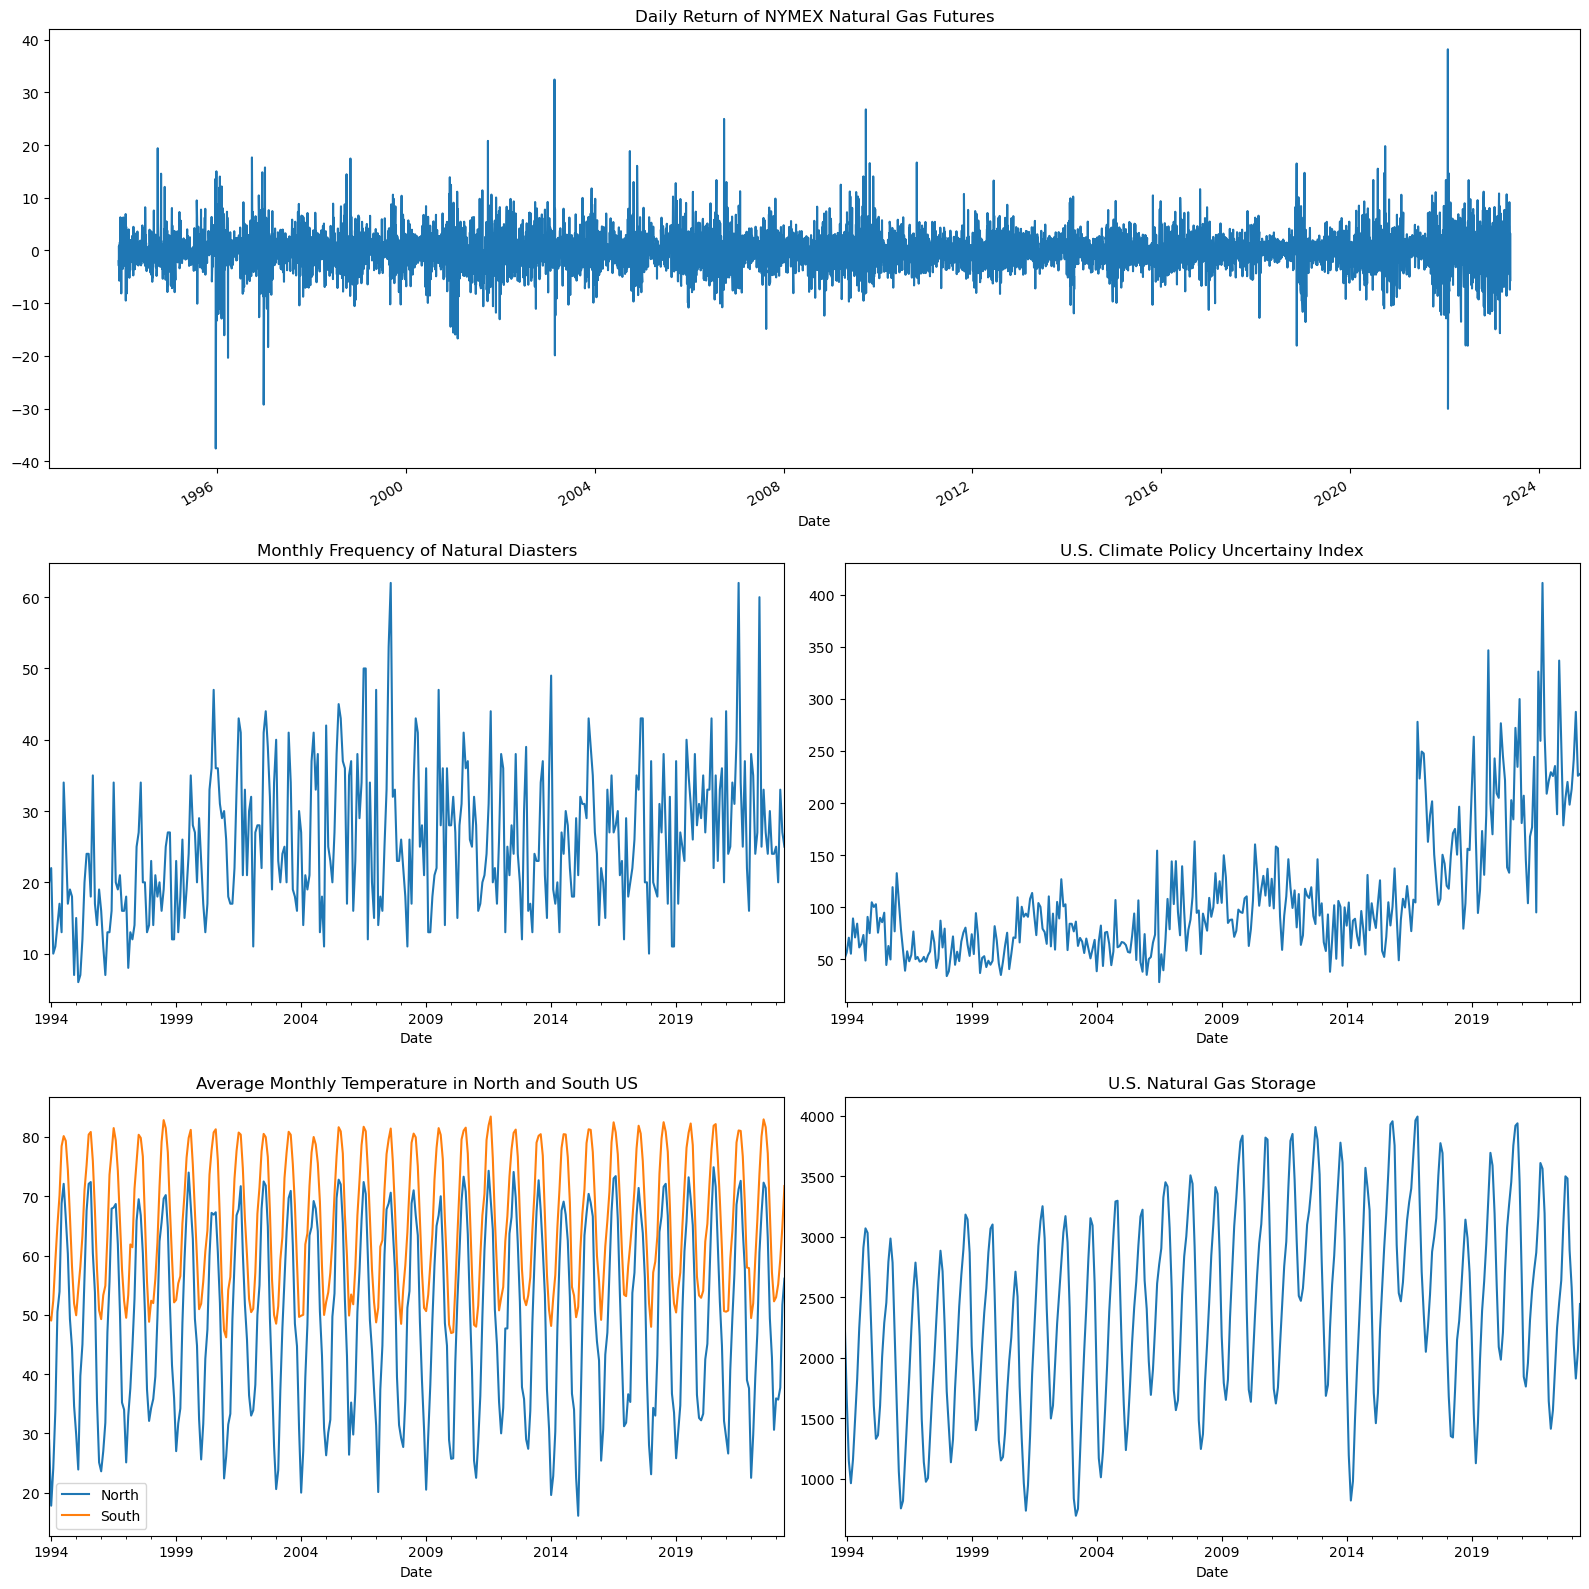

In [4]:
plot_eda(data, study = 'extension')

In [5]:
get_descriptive_stats(data, study = 'extension')

,Obs,mean,std,min,max,skewness,kurtosis,ADF
Data,,,,,,,,
Natural gas futures return (daily),7346,-0.000382,3.680066,-37.574864,38.172676,0.126091,7.937305,-17.507209
CPU Index,354,107.885638,62.028806,28.161927,411.288806,1.622722,2.837640,-0.389236
d. ln(CPU Index),353,0.004246,0.367252,-1.701375,1.232682,-0.222687,0.958317,-7.677664
Natural disasters frequency,354,25.878531,9.849399,6.000000,62.000000,0.615416,0.419306,-2.777182
d. ln(Natural disasters frequency),353,0.000632,0.447456,-1.427116,1.339774,-0.032108,0.360113,-13.839063
Average North Temp,354,49.439548,15.980881,16.100000,74.900000,-0.107517,-1.306489,-4.625529
Average South Temp,354,65.855579,11.216008,46.200000,83.450000,-0.027427,-1.427257,-2.860279
Storage,354,2434.714689,789.372983,696.000000,3995.000000,-0.103547,-0.830383,-2.418740
d. Storage,353,0.351275,385.647876,-1051.000000,524.000000,-0.717230,-0.768279,-5.814290


In [6]:
run_kpss_test(data, study = 'extension')

,KPSS Statistic,p-value
Data,,
Natural gas futures return (daily),0.056686,0.10
CPU Index,2.253542,0.01
d. CPU Index,0.142449,0.10
d. ln(CPU Index),0.067699,0.10
Natural disasters frequency,1.298460,0.01
d. Natural disasters frequency,0.047141,0.10
d. ln(Natural disasters frequency),0.027775,0.10
Average North Temp,0.066223,0.10
Average South Temp,0.085794,0.10


---
## Model Extensions 

### Model Ext 1: Realized Variance + Average North Temp + Storage, lag = 36

In [7]:
# Get required split for lag = 36
X_36train, X_36test, train36_returns, test36_returns, nbr_test_days36 =\
    is_os_split(data, '2022-12-01', 36, diff = 'first_order', study = 'extension')

In [8]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.05, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results1 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0::3], 36, get_twofactor_tau)) ## Limited Memory BFGS

results1

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16712.91151685396
        x: [ 4.882e-02  7.970e-02  9.049e-01  6.451e-02  9.410e-02
            -5.680e-02  1.044e+00 -1.945e+00]
      nit: 37
      jac: [ 2.547e-03  5.202e-02  5.675e-02 -6.912e-03 -1.422e-01
            -6.730e-02 -3.613e-01 -1.030e+00]
     nfev: 486
     njev: 54
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [9]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results1['x'], train36_returns, X_36train[::3], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results1['x'], 
              (train36_returns, X_36train[::3], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.048824,7.969698e-02,0.904854,6.451408e-02,0.094100,-0.056801,1.043863,-1.945338
p-val,0.079045,2.623890e-38,0.000000,2.993953e-07,0.343269,0.330526,0.013517,0.189114


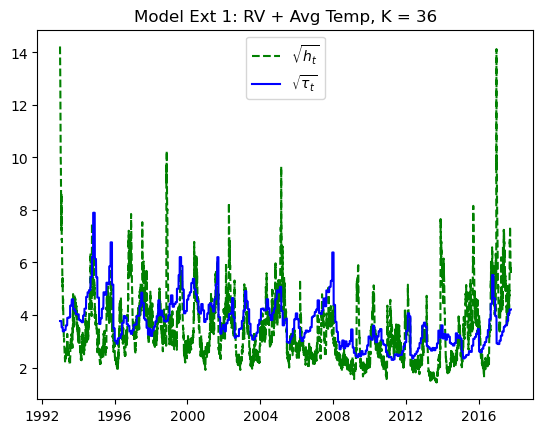

In [10]:
# Generate an array of time intervals
start_date = pd.to_datetime("1993-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

# Plot 
plot_results(date_array, ht, tau, title = 'Model Ext 1: RV + Avg Temp, K = 36')

### Model Ext 2: Realized Variance + Storage, lag = 36

In [11]:
# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0::4], 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16688.746583239015
        x: [ 4.340e-02  7.096e-02  9.103e-01  2.843e-02  8.628e-02
            -1.818e-01  1.691e+00  5.606e+00]
      nit: 101
      jac: [ 3.274e-02  1.783e-01  5.384e-02 -1.564e-01 -5.784e-02
             4.366e-03  2.547e-03  0.000e+00]
     nfev: 1116
     njev: 124
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [12]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], train36_returns, X_36train[::4], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (train36_returns, X_36train[::4], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.043398,7.095900e-02,0.910304,0.028434,0.086284,-0.181791,1.691131e+00,5.606142
p-val,0.103246,1.831843e-34,0.000000,0.000216,0.000041,0.218304,3.068600e-11,0.002159


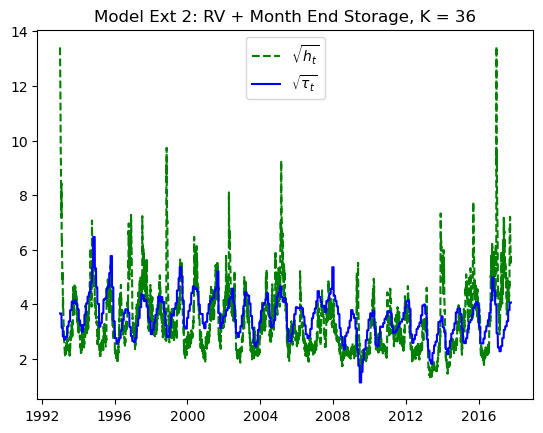

In [13]:
# Generate an array of time intervals
start_date = pd.to_datetime("1993-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

# Plot 
plot_results(date_array, ht, tau, title = 'Model Ext 2: RV + Month End Storage, K = 36')

### Model Ext 3: Realized Variance + Average North Temp + Storage, lag = 36

In [15]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, 
                          (X_36train[0], X_36train[3], X_36train[4]), 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results3

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16686.26656060509
        x: [ 4.321e-02  6.959e-02  9.109e-01  2.767e-02 -3.272e+00
             9.200e-02 -1.763e-01  1.121e+00  1.783e+00  5.702e+00]
      nit: 144
      jac: [ 7.240e-02  3.187e+00  2.454e+00 -2.948e+00  1.732e-01
             2.859e-01 -1.419e-02  4.111e-02  4.002e-03  6.330e-02]
     nfev: 2024
     njev: 184
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [16]:
loglik, logliks, e, tau, gt, ht, T =\
    GARCH_MIDAS(results3['x'], 
                train36_returns, 
                (X_36train[0], X_36train[3], X_36train[4]), 
                36, 
                get_tau=get_threefactor_tau, 
                full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (train36_returns, (X_36train[0], X_36train[3], X_36train[4]), 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.043208,6.958821e-02,0.91086,0.027673,-3.272081,0.092005,-0.176299,1.121458e+00,1.782651e+00,5.702352
p-val,0.103285,4.016909e-33,0.00000,0.000158,0.045252,0.000048,0.216454,4.972190e-15,2.825062e-08,0.001272


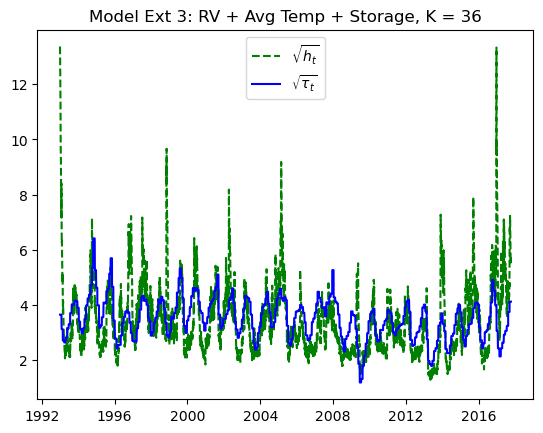

In [17]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model Ext 3: RV + Avg Temp + Storage, K = 36')

### Model Ext 4: Realized Variance + Monthly Disaster Frequency + Average North Temp + Storage, lag = 36

In [18]:
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, -2])

results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, 
                          (X_36train[0], X_36train[2], X_36train[3], X_36train[4]), 
                          36, get_fourfactor_tau)) ## Limited Memory BFGS

results4

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16683.375858406223
        x: [ 4.486e-02  6.830e-02  9.123e-01  2.618e-02  2.067e+00
            -2.767e+00  8.483e-02 -2.474e-01  1.281e+00  1.133e+00
             1.783e+00  5.928e+00]
      nit: 406
      jac: [-4.478e-01  1.192e+00  1.455e-01 -1.569e+00  1.237e-02
             3.562e-01 -4.376e-01  2.401e-02  3.238e-01 -2.863e-01
             1.855e-01  1.444e-01]
     nfev: 6006
     njev: 462
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>

In [19]:
loglik, logliks, e, tau, gt, ht, T =\
    GARCH_MIDAS(results4['x'], 
                train36_returns, 
                (X_36train[0], X_36train[2], X_36train[3], X_36train[4]),
                36, 
                get_tau=get_fourfactor_tau, 
                full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (train36_returns, 
               (X_36train[0], X_36train[2], X_36train[3], X_36train[4]), 
               36, get_fourfactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 
               'omega1', 'omega2', 'omega3', 'omega4','m'])

,mu,alpha,beta,theta1,theta2,theta3,theta4,omega1,omega2,omega3,omega4,m
values,0.044858,6.830193e-02,0.912283,0.026180,2.067390,-2.766564,0.084833,-0.247430,1.280881,1.133015e+00,1.782914e+00,5.928192
p-val,0.094740,4.340888e-32,0.000000,0.000204,0.016447,0.079184,0.000268,0.153546,0.000002,2.107131e-10,7.116371e-07,0.000615


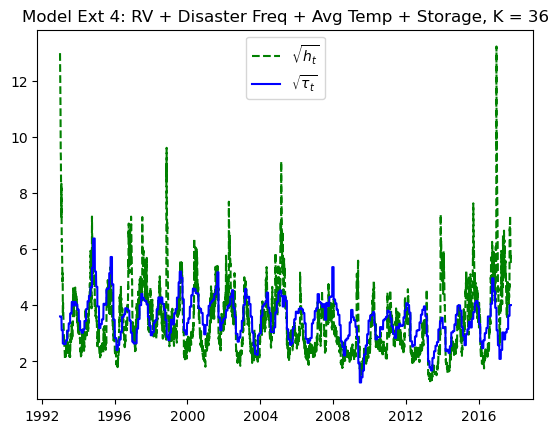

In [20]:
# Plot 
plot_results(date_array, ht, tau, 
             title = 'Model Ext 4: RV + Disaster Freq + Avg Temp + Storage, K = 36')

---
## Out-sample Analysis


In [21]:
df_realized_vol = pd.read_csv('./data/intraday_realized_volatility.csv', 
                              encoding_errors='ignore')

df_realized_vol.set_index('Date', inplace = True)
df_realized_vol.index = pd.to_datetime(df_realized_vol.index)

realized_vol = np.array(df_realized_vol.loc[df_realized_vol.index >= '2022-12-01', 'Volatility'])

In [22]:
LMSE1, LMAE1 = out_sample_test(test36_returns, 
                               realized_vol, 
                               X_36test[::3], 
                               36, 
                               results1,
                               nbr_test_days36, 
                               [10,30,60,90,118])

LMSE2, LMAE2 = out_sample_test(test36_returns, 
                               realized_vol, 
                               X_36test[::4], 
                               36, 
                               results2, 
                               nbr_test_days36, 
                               [10,30,60,90,118])

LMSE3, LMAE3 = out_sample_test(test36_returns, 
                               realized_vol, 
                               (X_36test[0], X_36test[3], X_36test[4]), 
                               36, 
                               results3, 
                               nbr_test_days36,
                               [10,30,60,90,118])

LMSE4, LMAE4 = out_sample_test(test36_returns, 
                               realized_vol, 
                               (X_36test[0], X_36test[2], X_36test[3], X_36test[4]), 
                               36, 
                               results4,
                               nbr_test_days36,
                               [10,30,60,90,118])


In [23]:
pd.DataFrame({
    'MSE (RV + Avg Temp, K = 36)' : LMSE1,
    'MAE (RV + Avg Temp, K = 36)' : LMAE1,
    'MSE (RV + Storage, K = 36)' : LMSE2,
    'MAE (RV + Storage, K = 36)' : LMAE2,
    'MSE (RV + Avg Temp + Storage, K = 36)' : LMSE3,
    'MAE (RV + Avg Temp + Storage, K = 36)' : LMAE3,
    'MSE (RV + EMDAT + Avg Temp + Storage, K = 36)' : LMSE4,
    'MAE (RV + EMDAT + Avg Temp + Storage, K = 36)' : LMAE4
}, index = ['10 days forecast','30 days forecast','60 days forecast','90 days forecast', '118 days forecast']).T

,10 days forecast,30 days forecast,60 days forecast,90 days forecast,118 days forecast
"MSE (RV + Avg Temp, K = 36)",0.000038,0.000080,0.000114,0.000156,0.000144
"MAE (RV + Avg Temp, K = 36)",0.005045,0.007172,0.008592,0.010401,0.010025
"MSE (RV + Storage, K = 36)",0.000032,0.000064,0.000078,0.000097,0.000092
"MAE (RV + Storage, K = 36)",0.004526,0.006581,0.007203,0.008156,0.007955
"MSE (RV + Avg Temp + Storage, K = 36)",0.000028,0.000060,0.000071,0.000090,0.000084
"MAE (RV + Avg Temp + Storage, K = 36)",0.004244,0.006333,0.006833,0.007815,0.007621
"MSE (RV + EMDAT + Avg Temp + Storage, K = 36)",0.000025,0.000057,0.000070,0.000087,0.000083
"MAE (RV + EMDAT + Avg Temp + Storage, K = 36)",0.004023,0.006198,0.006801,0.007744,0.007597


In [24]:
models_to_test =\
  [(test36_returns, X_36test[::3],36,results1, nbr_test_days36),
  (test36_returns, X_36test[::4],36,results2, nbr_test_days36),
  (test36_returns, (X_36test[0], X_36test[3], X_36test[4]),36,results3, nbr_test_days36),
  (test36_returns, (X_36test[0], X_36test[2], X_36test[3], X_36test[4]),36,results4, nbr_test_days36)]

MCS_MSE_10, MCS_MAE_10 =\
    mcs_test(realized_vol, 
             models_to_test,
             10)

MCS_MSE_30, MCS_MAE_30 =\
    mcs_test(realized_vol, 
             models_to_test,
             30)

MCS_MSE_60, MCS_MAE_60 =\
    mcs_test(realized_vol, 
             models_to_test,
            60)

MCS_MSE_90, MCS_MAE_90 =\
    mcs_test(realized_vol, 
             models_to_test,
             90)

MCS_MSE_118, MCS_MAE_118 =\
    mcs_test(realized_vol, 
             models_to_test,
             118)

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 1502.62model/s]


In [25]:
MCS10 = pd.merge(MCS_MSE_10.sort_index()[['pvalues']],MCS_MAE_10.sort_index()[['pvalues']], on = 'models',how='inner')
MCS30 = pd.merge(MCS_MSE_30.sort_index()[['pvalues']],MCS_MAE_30.sort_index()[['pvalues']], on = 'models',how='inner')
MCS60 = pd.merge(MCS_MSE_60.sort_index()[['pvalues']],MCS_MAE_60.sort_index()[['pvalues']], on = 'models',how='inner')
MCS90 = pd.merge(MCS_MSE_90.sort_index()[['pvalues']],MCS_MAE_90.sort_index()[['pvalues']], on = 'models',how='inner')
MCS118 = pd.merge(MCS_MSE_118.sort_index()[['pvalues']],MCS_MAE_118.sort_index()[['pvalues']], on = 'models',how='inner')

In [26]:
merged_mcs = pd.concat([MCS10, MCS30,MCS60,MCS90,MCS118], keys=['10 days', '30 days', '60 days', '90 days', '120 days'])
merged_mcs = merged_mcs.rename(columns={'pvalues_x' : 'MCS_mae', 'pvalues_y' : 'MCS_mse'})

new_index_values =\
    ['RV + Avg Temp (K = 36)', 
     'RV + Storage (K = 36)', 
     'RV + Avg Temp + Storage (K = 36)', 
     'RV + EMDAT + Avg Temp + Storage (K = 36)']  # New values for the second level index

merged_mcs.index = merged_mcs.index.set_levels(new_index_values, level=1)
merged_mcs

MCS_mae  MCS_mse
         models                                                    
10 days  RV + Avg Temp (K = 36)                        0.0      0.0
         RV + Storage (K = 36)                         0.0      0.0
         RV + Avg Temp + Storage (K = 36)              0.0      0.0
         RV + EMDAT + Avg Temp + Storage (K = 36)      1.0      1.0
30 days  RV + Avg Temp (K = 36)                        0.0      0.0
         RV + Storage (K = 36)                         0.0      0.0
         RV + Avg Temp + Storage (K = 36)              0.0      0.0
         RV + EMDAT + Avg Temp + Storage (K = 36)      1.0      1.0
60 days  RV + Avg Temp (K = 36)                        0.0      0.0
         RV + Storage (K = 36)                         0.0      0.0
         RV + Avg Temp + Storage (K = 36)              0.0      0.0
         RV + EMDAT + Avg Temp + Storage (K = 36)      1.0      1.0
90 days  RV + Avg Temp (K = 36)                        0.0      0.0
         RV + Storage (K = 36)                         0.0      0.0
         RV + Avg Temp + Storage (K = 36)              0.0      0.0
         RV + EMDAT + Avg Temp + Storage (K = 36)      1.0      1.0
120 days RV + Avg Temp (K = 36)                        0.0      0.0
         RV + Storage (K = 36)                         0.0      0.0
         RV + Avg Temp + Storage (K = 36)              0.0      0.0
         RV + EMDAT + Avg Temp + Storage (K = 36)      1.0      1.0

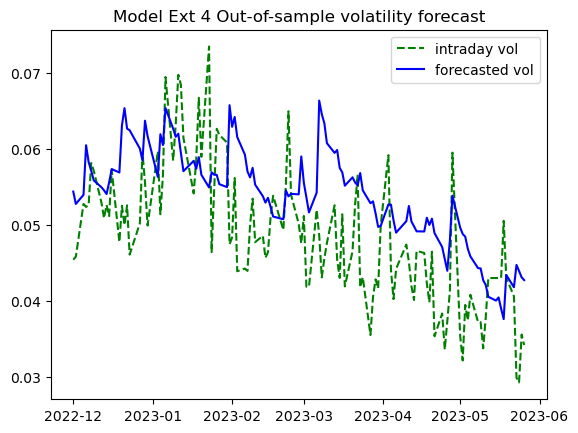

In [27]:
loglik, logliks, e, tau, gt, ht, T =\
    GARCH_MIDAS(results4['x'], 
                test36_returns, 
                (X_36test[0], X_36test[2], X_36test[3], X_36test[4]),
                36, 
                get_tau=get_fourfactor_tau, 
                full_output=True)

rlzd_daily_vol = realized_vol/np.sqrt(252)
forecast_vol = np.sqrt(ht[-nbr_test_days36:])/100

x = np.array(data.index[data.index >= '2022-12-01'])

plt.title("Model Ext 4 Out-of-sample volatility forecast")

plt.plot(x, rlzd_daily_vol, 'g--', label = 'intraday vol')
plt.plot(x, forecast_vol,'b-', label = 'forecasted vol')
plt.legend()
plt.show()